In [23]:
import os
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

import SortedNoDupeBedOverlap as bdO

import pandas as pd
import numpy as np
import csv

import scipy



In [2]:
import getopt, sys

full_cmd_arguments = sys.argv
argument_list = full_cmd_arguments[1:]
short_options = "i:r:b:fvo"
long_options = ["inpu=", "ref_folder=", "background=","figure", "verbose", "output"]

try:
    arguments, values = getopt.getopt(argument_list, short_options, long_options)
except getopt.error as err:
    print (str(err))
    sys.exit(2)
    
figure = False
verbose = False
inP = False
outP = False
ref = False
bkg = False
    
for a, v in arguments:
    if a in ("-v", "--verbose"):
        verbose = True
    elif a in ("-f", "--figure"):
        figure = True
    elif current_argument in ("-o", "--output"):
        outP = True
    elif current_argument in ("-i", "--input"):
        inP = v
    elif current_argument in ("-r", "--ref_folder"):
        ref = v
    elif current_argument in ("-b", "--background="):
        bkg = v

if (not inP):
    print("Missing input file")
    sys.exit(2)
if (not bkg):
    print("Missing background file")
    sys.exit(2)


Missing input file


SystemExit: 2

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
#manually set arguments for use in ipynb
inP = "demo_data.csv"
bkg = "GSE97887_peaks_Occ1_Fcx1_Cbh1_joint_spp_RMMMcombined_RMrepeatmask100_bandwidth500_step100_thr5_span10_fdr1e-07.sorted.bed"
verbose = True
Figure = True
outP = True

In [4]:
if(verbose): print("Reading Input File")

Reading Input File


In [5]:
data = pd.read_csv(inP)

In [6]:
data.rename( columns={'Unnamed: 0':'id2peak'}, inplace=True)
id2peak = []
for c in data['id2peak']:
    temp = c.split('_')
    id2peak.append((temp[0], int(temp[1]), int(temp[2])))

id2peak.sort( key = lambda x: (x[0], x[1]))
#id2peak.sort(key=lambda x: x[1])
#id2peak = np.array(id2peak, dtype=object)

In [7]:
if(verbose): print("Calculating Bed Overlaps")

Calculating Bed Overlaps


In [8]:
#fn_bk1 = 'GSE97887_peaks_Occ1_Fcx1_Cbh1_joint_spp_RMMMcombined_RMrepeatmask100_bandwidth500_step100_thr5_span10_fdr1e-07.sorted.bed'
fn_bk1_data = bdO.BedScan(bkg, "\t")

intersect = bdO.BedOverlap(id2peak, fn_bk1_data, 50)

id2target = ['Ex', 'In', 'Mic', 'End', 'Ast', 'Opc', 'Oli']
if(ref): tmp = ref + '/GSE97887_occ1_MAINSPLITS.%s.diffPeaks.sorted.bed'
else: tmp = 'GSE97887_occ1_MAINSPLITS.%s.diffPeaks.sorted.bed'
fn_target = [(c, tmp % c)  for c in id2target]

set2_ref = []

for c, f1 in fn_target:
    scan = bdO.BedScan(f1, "\t")
    s2 = bdO.BedOverlap(id2peak, scan, 50)
    set2_ref.append((c, s2))
    

In [9]:
if(verbose): print("Calculating Fischer Exact Scores")

Calculating Fischer Exact Scores


In [69]:
import scipy.stats as stats
def get_fisher_exact(s1, s2, sbk):
    
    n1 = len(s1 & s2)
    n2 = len(s1 & (sbk - s2))
    n3 = len((sbk - s1) & s2)
    n4 = len((sbk - s1) & (sbk - s2))

    mat = [[n1, n2], [n3, n4]]

    oddsratio, pvalue = stats.fisher_exact(mat, 'greater')
    return oddsratio, pvalue

In [ ]:
scores = []
mat1 = data.drop("id2peak",axis=1).to_numpy()

interset = set(intersect[:,0])

for i in range (mat1.shape[1]):
    s1 = set([id2peak[j] for j in np.where(mat1[:, i] > 0.5)[0]])
    tmp = []
    for c, s2 in set2_ref:
        s2 = set(s2[:,0])
        if not (s1 & s2):
            tmp.append(0)
        else:
            tmp.append(get_fisher_exact(s1, s2, interset)[0])
    scores.append(tmp)

In [12]:
if(verbose): print("Intializing TSNE")

Intializing TSNE


In [13]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

scoresNP = np.array(scores)
mat = mat1.T / np.sum(mat1.T, axis = 1, keepdims=True)
clf0 = PCA(n_components = 10)
if(verbose): clf1 = TSNE(n_components = 2, verbose=1)
else: clf1 = TSNE(n_components = 2)
df_tsne = clf1.fit_transform(clf0.fit_transform(mat))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3629 samples in 0.008s...
[t-SNE] Computed neighbors for 3629 samples in 0.247s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3629
[t-SNE] Computed conditional probabilities for sample 2000 / 3629
[t-SNE] Computed conditional probabilities for sample 3000 / 3629
[t-SNE] Computed conditional probabilities for sample 3629 / 3629
[t-SNE] Mean sigma: 0.000241
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.335640
[t-SNE] KL divergence after 1000 iterations: 1.904744


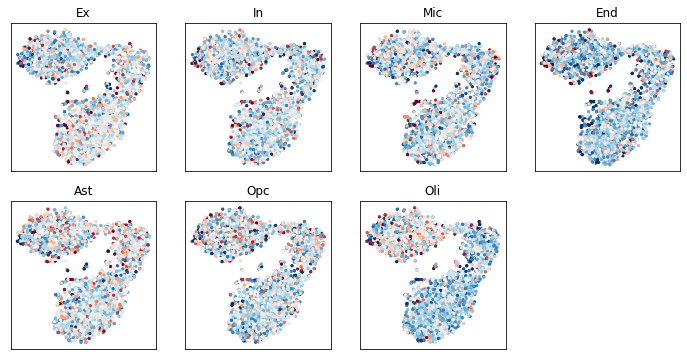

In [14]:
fig, axes = plt.subplots(2, 4, figsize = (12, 6))

for i, (c, _) in enumerate(set2_ref):
    ax = axes[i // 4, i % 4]
    vmax, vmin = np.percentile(scoresNP[:, i], 99), np.percentile(scoresNP[:, i], 1)
    ax.scatter(df_tsne[:,0], df_tsne[:,1], 
            s = 5, c = scoresNP[:, i], cmap = 'RdBu_r', vmax = vmax, vmin = vmin)
    ax.set_title(c)
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[-1, -1].axis('off')

if(figure): plt.savefig(inP + '.png')
else: plt.show()

In [ ]:
def output():
    if(verbose): print("Outputing")
    #write output file for the intersection
    IntersectFile = open(fn_bk1+'Intersection.tsv', "w+")
    IntersectFile.write("Chr in Data\tChr in Bk\tOverlap percent\n")
    IntersectWriter= csv.writer(IntersectFile, delimiter='\t')
    for line in intersect: IntersectWriter.writerow(line)
    IntersectFile.close()
    
    #write output file for the intersection of cell types
    for c, s2 in set2_ref:
        setFile = open( c+")_Intersection.tsv" , "w+")
        setFile.write("Chr in Data\tChr in Bk\tOverlap percent\n")
        setWriter= csv.writer(setFile, delimiter='\t')
        for line in s2: setWriter.writerow(line)
        setFile.close()
    
    #write output file for fischer exact scores
    ScoreFile = open('DatafischerScores.tsv', "w+")
    ScoreFile.write("Ex\tIn\tMic\tEnd\tAst\tOpc\tOli\n")
    IntersectWriter= csv.writer(IntersectFile, delimiter='\t')
    for line in intersect: IntersectWriter.writerow(line)
    sFile.close()


In [ ]:
if(verbose): print("Outputting")
if(output) output()